# FAIR - Amazon Reviews - Data Inspection


## I. Load Necessary Libraries

In [3]:
import pandas
import numpy
import json5
import functools
import json
from matplotlib import pyplot
from typing import Optional, Any, Coroutine, Union, Dict, List
import nltk
from nltk.corpus import stopwords
import string
import contractions

nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lbypatrick/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/lbypatrick/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lbypatrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lbypatrick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# II. Load and clean input data

In [4]:
df_comments = pandas.read_json("data/Cell_Phones_and_Accessories_5.json", lines=True)
df_comments.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [5]:
# Drop irrelevant columns
cleaned = df_comments.drop(
    columns=[
        column
        for column in df_comments.columns
        if column not in ["reviewText", "overall"]
    ]
)

# Rename rating column
cleaned.rename(columns={"overall": "rating"}, inplace=True)

# reanme columns to snake case
cleaned.columns = cleaned.columns.str.replace(
    "(?<=[a-z])(?=[A-Z])", "_", regex=True
).str.lower()


# Clean review bodies
comments = cleaned["review_text"].tolist()

# Remove extra Line breaks and indents
comments = [
    entry.strip().replace("\n\n", "\n").replace("\t", " ") for entry in comments
]

# Fix contractions (I've --> I have)
comments = [
    contractions.fix(entry) for entry in comments
]
lengths = [len(entry) for entry in comments]

cleaned["review_text"] = comments
cleaned["length"] = lengths

In [6]:
display(cleaned.head())

,review_text,rating,length
0,They look good and stick good! I just do not l...,4,193
1,These stickers work like the review says they ...,5,160
2,These are awesome and make my phone look so st...,5,166
3,Item arrived in great time and was in perfect ...,4,277
4,"awesome! stays on, and looks great. can be use...",5,135


# III. Data Inspection

Exploring RATING:
Distribution: 


count    194439.000000
mean          4.129912
std           1.222499
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

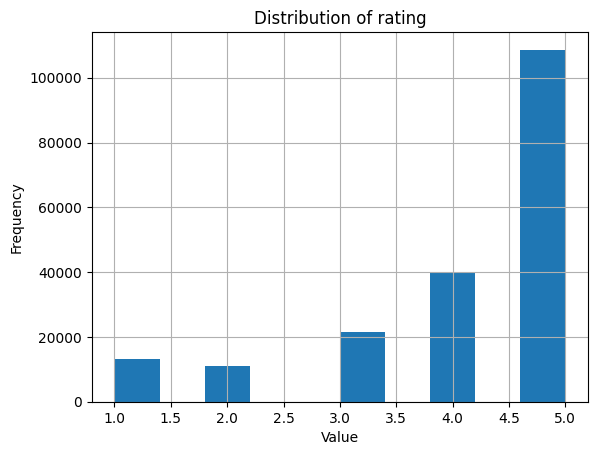




Exploring LENGTH:
Distribution: 


count    194439.000000
mean        494.005220
std         752.070677
min           0.000000
25%         144.000000
50%         249.000000
75%         535.000000
max       32189.000000
Name: length, dtype: float64

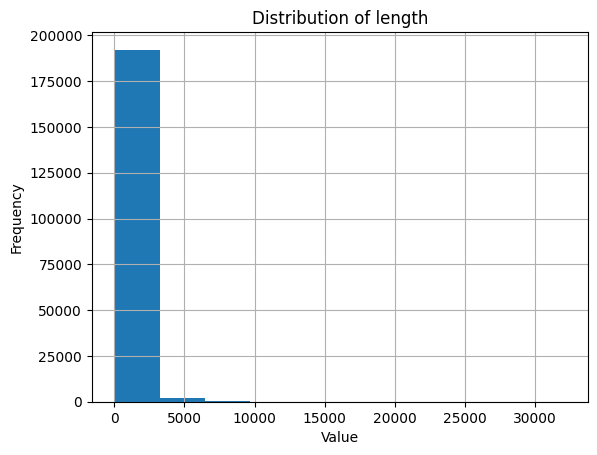

In [7]:
for col in cleaned.columns:
    if col == "review_text":
        continue

    print(f"Exploring {col.upper()}:")

    print("=" * 30)
    print("Distribution: ")
    display(cleaned[col].describe())

    cleaned.hist(column=[col])

    pyplot.title(f"Distribution of {col}")
    pyplot.xlabel("Value")
    pyplot.ylabel("Frequency")

    pyplot.show()

    print("\n\n")

In [8]:
# Let's do word frequency
freqs = {}

puncs = set(string.punctuation)
stopwords = set(nltk.corpus.stopwords.words("english"))
bad_tokens = {*stopwords, *puncs}

for idx, comment in enumerate(comments):
    print(f"\rPROGRESS: {idx + 1} / {len(comments)}", end="")

    word_tokens = nltk.word_tokenize(comment)
    filtered_sentence = [w for w in word_tokens if w not in bad_tokens]

    for word in filtered_sentence:
        if word not in freqs:
            freqs[word] = 1
        else:
            freqs[word] += 1

print("\nAll Done.")

PROGRESS: 194439 / 194439
All Done.


In [9]:
sorted_freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

filtered_freqs = {k: v for k, v in sorted_freqs.items() if len(k) > 1}

Text(0.5, 1.0, 'Frequencies of top 50 words')

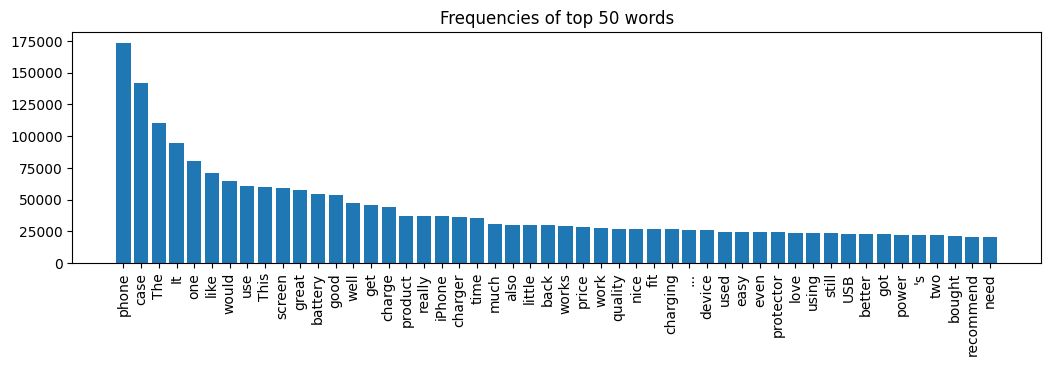

In [10]:
top_n = 50
top_words = list(filtered_freqs.keys())[:top_n]
top_counts = list(filtered_freqs.values())[:top_n]

pyplot.figure(figsize=(top_n / 4, 3))
pyplot.bar(top_words, top_counts, align="center")
pyplot.xticks(rotation=90)
pyplot.title(f"Frequencies of top {top_n} words")

In [11]:
pos_dict = dict(nltk.pos_tag(list(filtered_freqs.keys()), tagset="universal"))

# now let's look at those words that can potentially suggset feelings, in this case they are adjectives, adverbs, and conjunctions
emotion_word_freqs = {
    k: v for k, v in filtered_freqs.items() if pos_dict[k] in ["ADJ", "ADV", "CONJ"]
}

Text(0.5, 1.0, 'Frequencies of top 50 EMOTIONAL words')

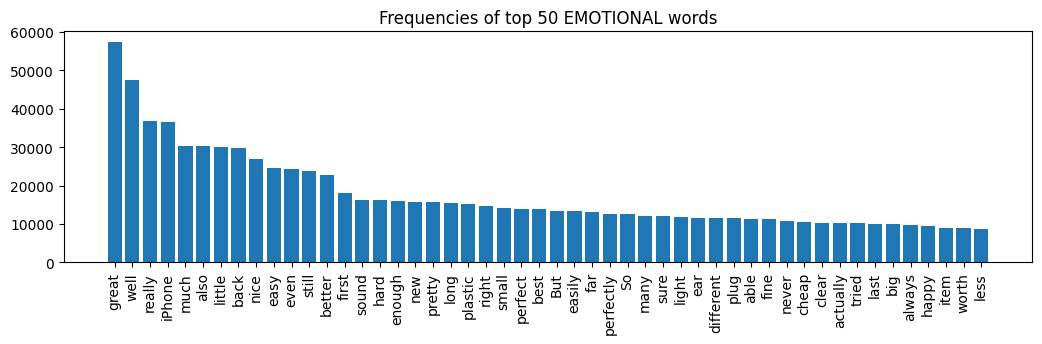

In [12]:
top_emo_words = list(emotion_word_freqs.keys())[:top_n]
top_emo_counts = list(emotion_word_freqs.values())[:top_n]

pyplot.figure(figsize=(top_n / 4, 3))
pyplot.bar(top_emo_words, top_emo_counts, align="center")
pyplot.xticks(rotation=90)
pyplot.title(f"Frequencies of top {top_n} EMOTIONAL words")